In [48]:
# Copied from https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions
# Modified the code to make it more generic 
# Included "hard coded data" for Turkey and Republic of Ireland (ROI)

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Curve Fitting functions

## 1 - Logistic regression

In [50]:
# The logistic model describes an infection growth that is going to stop in the future, 

In [51]:
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



In [52]:
def calculate_sol_days(x, logistic_model_func, a_lr, b_lr, c_lr):
    # The expected infection end can be calculated as that particular day at which the cumulative 
    # infected people count is equal to the c parameter rounded to the nearest integer.
    sol_date = int(fsolve(lambda x : logistic_model_func(x, a_lr, b_lr, c_lr) - int(c_lr), b_lr))
    return sol_date

In [53]:
def print_sol_date(x, logistic_model_func, a_lr, b_lr, c_lr):
    # The expected infection end can be calculated as that particular day at which the cumulative 
    # infected people count is equal to the c parameter rounded to the nearest integer.
    sol_days = calculate_sol_days(x, logistic_model, a_lr,b_lr,c_lr)
    print("Days since new year: {}".format(sol_days)) 
    # check from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
    sol_date = datetime(2020,1,1) + timedelta(days=sol_days-1)
    print(sol_date.strftime("%d %B %Y"))

## 2 - Exponential growth

In [54]:
# The exponential model describes an unstoppable infection

In [55]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

## 3 - Generic code for curve fitting

In [56]:
def fit_curve(model_function, x, y, p0, population):
    # methods: [lm, trf, dogbox]
    # Method 'lm' only works for unconstrained problems. Use 'trf' or 'dogbox' instead.
    fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000, method="trf", 
                    bounds=(0, [np.inf, np.inf, population]))
    #fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000, method="lm")
    # print("fit_result: {}".format(fit))
    a , b, c = fit[0]
    # standard error 
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    return a , b, c, errors

##  4 - Plot & evaluate

In [57]:
# TODO convert func, abc_tuple into struct and pass array of that struct
def plot_curves(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    sol = calculate_sol_days(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    
    # Predicted logistic curve
    plt.plot(x+pred_x, 
             [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
             label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, 
             [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x+pred_x], 
             label="Exponential model" )
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,abc_tuple_lr[2]*1.1))
    plt.show()
    

def plot_curves_countries(logistic_model_func, country_2_abc_tuple_lr, country_2_xy):
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    
    for country, abc_tuple_lr in country_2_abc_tuple_lr.items():
        x = country_2_xy[country][0]
        y = country_2_xy[country][1]
        
        sol = calculate_sol_days(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
        pred_x = list(range(max(x),sol))
    
        # Real data
        plt.scatter(x,y, color="red")
    
        # Predicted logistic curve
        plt.plot(x+pred_x, 
                 [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
                 label="Logistic model({})".format(country))
        
    
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.legend()
    plt.show()

In [58]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
def calculate_mse(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    y_pred_logistic = [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x]
    y_pred_exp =  [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x]
    mse_lr = mean_squared_error(y,y_pred_logistic)
    mse_exp = mean_squared_error(y,y_pred_exp)
    return mse_lr, mse_exp

# Execute logistic regression & exponential growth

In [59]:
# Current date:
today = datetime.now()
print(today.strftime("%d %B %Y"))

25 April 2020


In [60]:
# generic parameters
days_since_start = 45 # predicted that after days_since_start maximum number of infections occurs
percentage_of_population = 0.05 # percentage_of_population predicted to be infected at the infection’s end
p0_a = 2

In [61]:
# To be used later
country_2_abc_tuple_lr = {}
country_2_xy = {}

## 1 - Data on Italy

### 1.1 - Load data

In [62]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [63]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
56,2020-04-20T17:00:00,ITA,24906,2573,27479,80758,108237,-20,2256,48877,24114,181228,1398024,943151.0,dc-IT-0007,dc-EN-0007
57,2020-04-21T17:00:00,ITA,24134,2471,26605,81104,107709,-528,2729,51600,24648,183957,1450150,971246.0,pd-IT-0013,pd-EN-0013
58,2020-04-22T17:00:00,ITA,23805,2384,26189,81510,107699,-10,3370,54543,25085,187327,1513251,1015494.0,NaN,NaN
59,2020-04-23T17:00:00,ITA,22871,2267,25138,81710,106848,-851,2646,57576,25549,189973,1579909,1052577.0,pd-IT-0015;pd-IT-0017,pd-EN-0015;pd-EN-0017
60,2020-04-24T17:00:00,ITA,22068,2173,24241,82286,106527,-321,3021,60498,25969,192994,1642356,1147850.0,NaN,NaN


In [64]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%dT%H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days  )

In [65]:
df.tail()

,data,totale_casi
56,110,181228
57,111,183957
58,112,187327
59,113,189973
60,114,192994


In [66]:
# Data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [67]:
# p0: Initial guess for the parameters (length N)
population = 60.48 * 1e6# 60.48 million
start_date = 54 # 54th day of the year


p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population 
p0_lr = [p0_a, p0_b, p0_c ] 
p0_exp = [1,1,1]

### 1.2 - Execute Logistic Regression

In [68]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:8.134660675334413 , b_lr:88.63201056306532, c_lr:191623.38967637526 
errors_lr: [0.2311725653130961, 0.3365297199934909, 2473.2931734689655]


In [69]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 195
13 July 2020


### 1.3 - Execute Exponential Growth

In [70]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:1966.9414478477265 , b_exp:0.04185949697291261, c_exp:0.28118301902820275 
errors_exp: [101294516.41616088, 0.0022769588463305967, 1230270.343445837]


### 1.4 - Plot

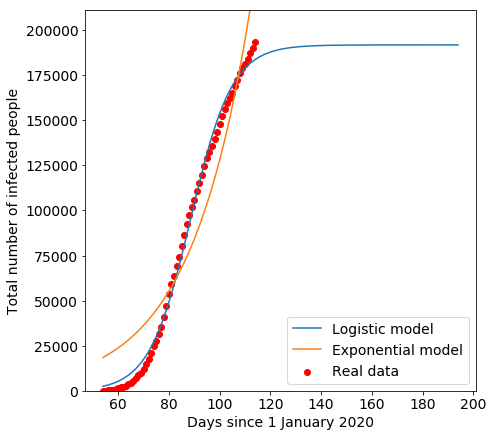

In [71]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 1.5 - Evaluate

In [72]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.

In [73]:
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 18900624.508011285
Exponential model MSE: 384863115.2240961


In [74]:
country = "Italy"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 2 - Data on Republic of Ireland

### 2.1 - Load data

In [75]:
# TODO Get data automatically from some source
# Starts at Feb 29
population = 4.83 * 1e6 # 4.83 million
start_date = 60 # start_date-th day of the year

# # NOTE: Big jump from 6574 to 8089. Turned out some tests are evaluated in another country, namely Germany, 
# # and the results obtained weeks later.
# total_cases = [1, 1, 1, 2 , 6, 13, 18, 19, 21, 24, 34, 43, 70, 90, 129, 169, 223, 292, 366, 557, 683, 785, 906, 1125,
#               1329, 1564, 1819, 2121, 2415, 2615, 2910, 3235, 3447, 3849, 4273, 4604, 4994, 5364, 5709, 6074, 6574,
#               8089, 8928, 9655]

# Alternatively, the unexpected (results obtained from abroad) distributed to previous X days
# April 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
cases_abroad = [1035, 286, 297, 465, 284, 411, 95, 112, 148, 48]
days_to_distribute = 15 + len(cases_abroad) # first val. is heuristically decided
avg_cases_per_day_abroad = sum(cases_abroad) / days_to_distribute # note the floating point results
total_cases_base = [1, 1, 1, 2 , 6, 13, 18, 19, 21, 24, 34, 43, 70, 90, 129, 169, 223, 292, 366, 557, 683, 785, 906, 1125,
              1329, 1564, 1819, 2121, 2415, 2615, 2910, 3235, 3447, 3849, 4273, 4604, 4994, 5364, 5709, 6074, 6574,
              7054, 7607, 8037, 8564, 9112, 9789, 10418, 11015, 11645, 12090] 

total_cases_base_and_distributed = total_cases_base[:-days_to_distribute] + [
    val + avg_cases_per_day_abroad for val in total_cases_base[days_to_distribute:]]

# April 20
new_confirmations_since_backlog = [401, 388, 631, 936, 577]
last_confirmed_and_distributed = total_cases_base_and_distributed[-1]

new_total_cases_base = [(last_confirmed_and_distributed + sum(new_confirmations_since_backlog[0:index+1])) 
                        for index in range(0, len(new_confirmations_since_backlog))]

total_cases = total_cases_base_and_distributed + new_total_cases_base

dates = list(range(start_date, start_date + len(total_cases)))

In [76]:
# Data
x = dates
y = total_cases

In [77]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population 
p0_lr = [p0_a, p0_b, p0_c] 
p0_exp = [1,1,1]

### 2.2 - Execute Logistic Regression

In [78]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:8.76208527052862 , b_lr:106.8156983402064, c_lr:19865.249148786676 
errors_lr: [0.21717208535963722, 0.604020461311999, 605.3702584940927]


In [79]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 205
23 July 2020


### 2.3 - Execute Exponential Growth

In [80]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:15.21013394033477 , b_exp:0.06718558655993048, c_exp:11.883730122686627 
errors_exp: [18944439.06718515, 0.0020000214979082843, 18538415.058735643]


### 2.4 - Plot

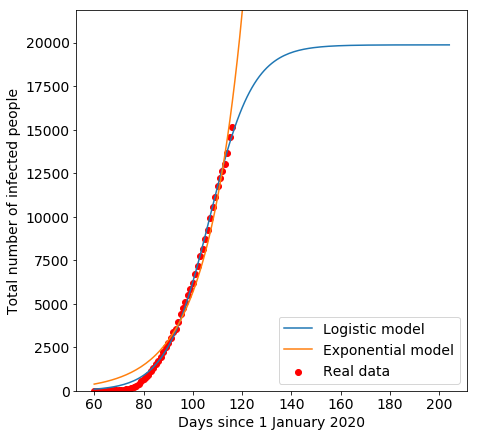

In [81]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 2.5 - Evaluate

In [82]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 45410.46302132171
Exponential model MSE: 437072.6517179816


In [83]:
country = "RO_Ireland"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 3 - Data on Turkey

### 3.1 - Load data

In [84]:
# TODO Get data automatically from some source
# Starts at March 11
population = 80.81 * 1e6 # 80.81 million
start_date = 71 # start_date-th day of the year

total_cases = [1, 2, 5, 6, 18, 47, 98, 191, 358, 670, 947, 1236, 1529, 1872, 2433, 3629, 5698, 7402, 9217, 10827, 
               13531, 15679, 18135, 20921, 23934, 27069, 30217, 34109, 38226, 42282, 47029, 52167, 56956, 61049,
               65111, 69392, 74193, 78546, 82329, 86306, 90980, 95591, 98674, 101790, 104912]
dates = list(range(start_date, start_date + len(total_cases)))

In [85]:
# Data
x = dates
y = total_cases

In [86]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population  
p0_lr = [p0_a, p0_b, p0_c] 
p0_exp = [1,1,1]

### 3.2 - Execute Logistic Regression

In [87]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:5.996203230148406 , b_lr:103.6454145544819, c_lr:118523.80947051349 
errors_lr: [0.127660782524753, 0.25226514640169834, 1892.7528532340186]


In [88]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 174
22 June 2020


### 3.3 - Execute Exponential Growth

In [89]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:21.573354071176375 , b_exp:0.07828704083926952, c_exp:4.710517057812645 
errors_exp: [25300337.56982117, 0.0036292788069666932, 14980237.708949532]


### 3.4 - Plot

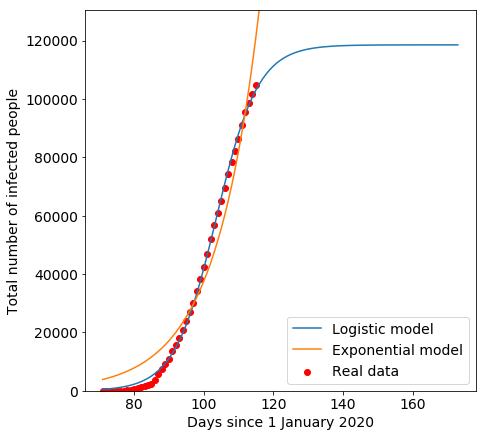

In [90]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 3.5 - Evaluate

In [91]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 1625334.1932609703
Exponential model MSE: 47899066.32397951


In [92]:
country = "Turkey"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 4 - Plot all

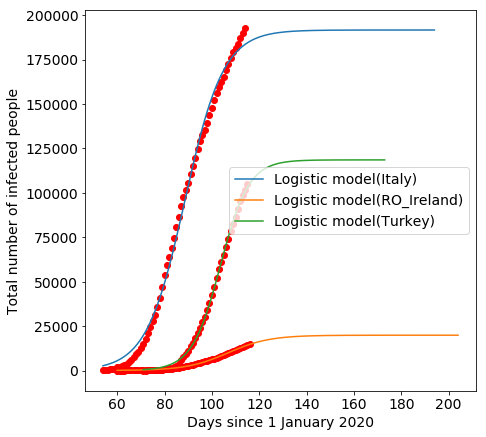

In [93]:
plot_curves_countries(logistic_model, country_2_abc_tuple_lr, country_2_xy)

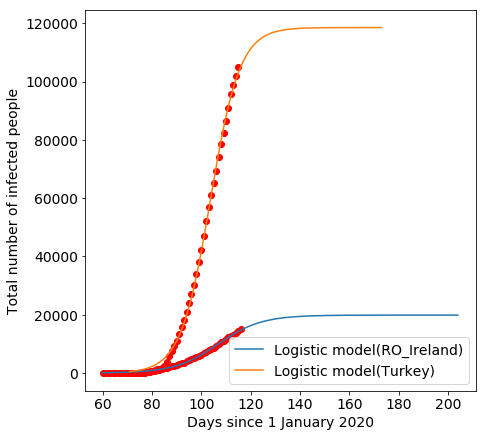

In [94]:
country_2_abc_tuple_lr.pop("Italy")
country_2_xy.pop("Italy")
plot_curves_countries(logistic_model, country_2_abc_tuple_lr, country_2_xy)